In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1mjIG99DruDMHmiZzntLI58Irn-2SbgcF')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meviole
Your Kaggle Key: ··········


  2%|▏         | 31.0M/1.33G [00:00<00:04, 320MB/s]

100%|██████████| 1.33G/1.33G [00:05<00:00, 239MB/s]


In [ ]:
import os

DATA_DIR = './celeba-dataset/img_align_celeba'
print(os.listdir(DATA_DIR))

['img_align_celeba']


In [ ]:
print(os.listdir(DATA_DIR + '/img_align_celeba')[:10])

['010987.jpg', '055105.jpg', '030494.jpg', '019744.jpg', '084551.jpg', '042290.jpg', '170768.jpg', '142058.jpg', '187330.jpg', '042607.jpg']


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline


In [ ]:
img_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
            T.Resize(img_size),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize(*stats)
]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def denorm(img_tensor):
  return img_tensor*stats[0][1] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

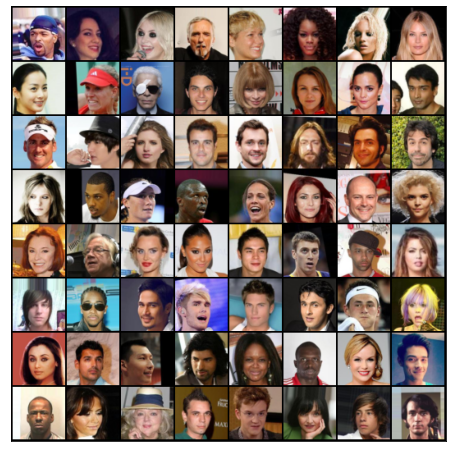

In [ ]:
show_batch(train_dl)

In [ ]:
!pip install jovian --upgrade --quiet
import jovian

In [ ]:
project_name= 'gan-celeb-faces'

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/swaingotnochill/gan-celeb-faces


'https://jovian.ai/swaingotnochill/gan-celeb-faces'

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: 
    return torch.device('CPU')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)


class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:

discriminator = nn.Sequential(
      #in : 3 x 64 x 64
      nn.Conv2d(3, 64, kernel_size=4, stride=2, padding= 1, bias= False), 
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2, inplace = True),
    
      #out : 64 x 32 x 32
      nn.Conv2d(64, 128 , kernel_size=4, stride=2, padding= 1, bias= False), 
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace = True),

      #out : 128 x 16 x 16

      nn.Conv2d(128,256, kernel_size=4, stride=2, padding= 1, bias= False), 
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace = True),
      
      #out : 256 x 8 x 8

      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding= 1, bias= False), 
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace = True),
    
      #out : 512 x 4 x 4

      nn.Conv2d(512, 1, kernel_size=4, stride=1, padding= 0, bias= False), 
      nn.Flatten(),
      nn.Sigmoid()
    

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


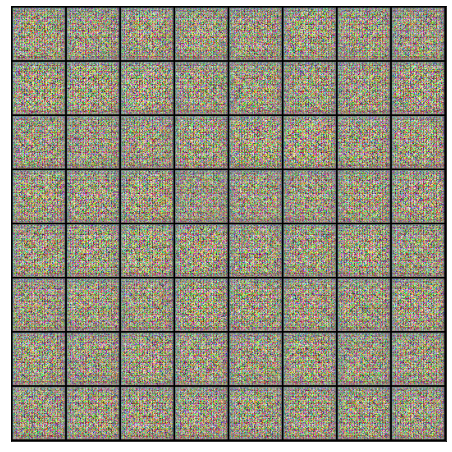

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [ ]:
generator = to_device(generator, device)

In [ ]:
import torch.nn.functional as F


In [ ]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets =  torch.ones(real_images.shape[0], 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent =  torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.shape[0], 1, device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss= F.binary_cross_entropy(preds, targets)
  loss.backward()
  opt_g.step()
  
  return loss.item()

  

In [ ]:
from torchvision.utils  import save_image

sample_dir = 'generated'
load_dir = 'Load&SavePth'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(load_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):

  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [ ]:
def save_load(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'load-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(load_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device = device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


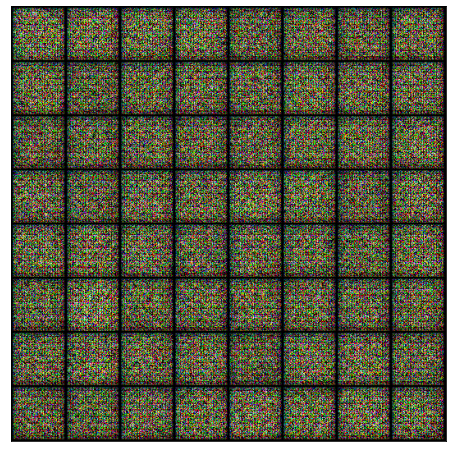

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
jovian.commit(project=project_name, environment=None)


[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/swaingotnochill/gan-celeb-faces


'https://jovian.ai/swaingotnochill/gan-celeb-faces'

In [ ]:
from tqdm.notebook import tqdm


In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images, _, in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
      
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    print('Epoch [{}/{}], loss_g: {:.4f},loss_d: {:.4f},real_score: {:.4f}, fake_score: {:.4f}'.format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    save_samples(epoch+start_idx,fixed_latent, show=False )
  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 25
lr = 0.0001

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr = lr, epochs = epochs)

[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs, lr)

In [ ]:
from IPython.display import Image


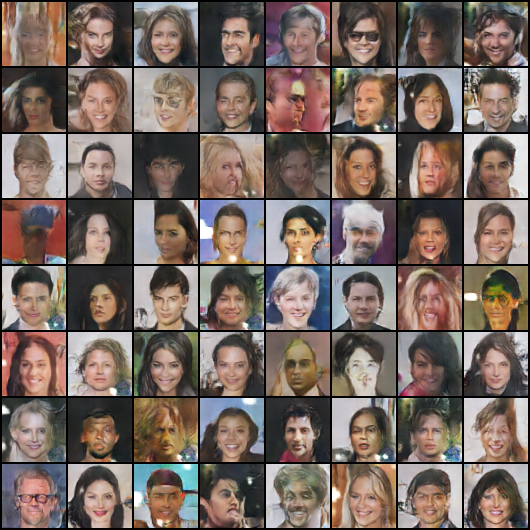

In [ ]:
Image('./generated/generated-images-0001.png')

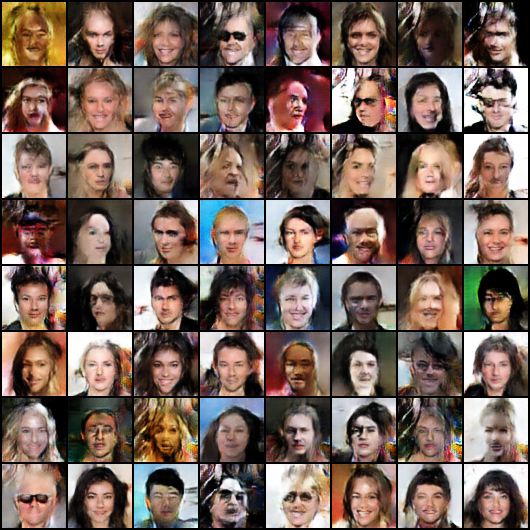

In [ ]:
Image('./generated/generated-images-0005.png')

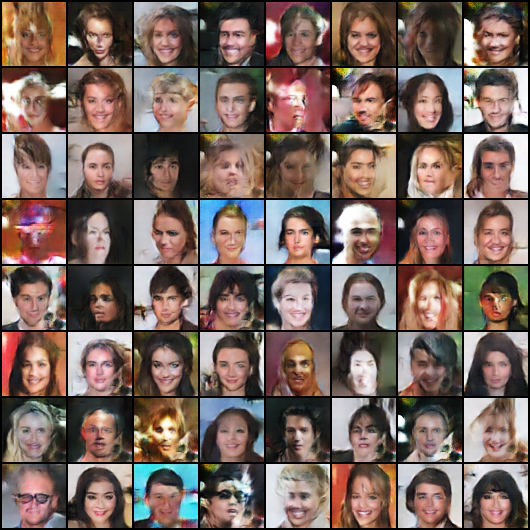

In [ ]:
Image('./generated/generated-images-0010.png')

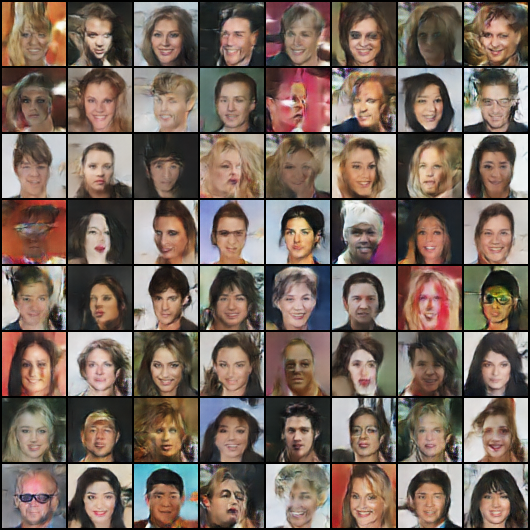

In [ ]:
Image('./generated/generated-images-0015.png')

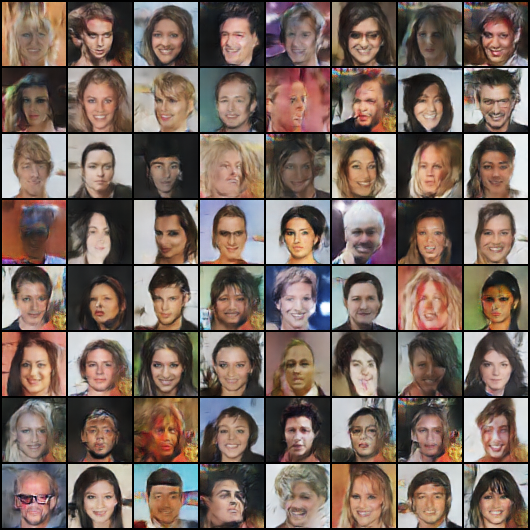

In [ ]:
Image('./generated/generated-images-0020.png')

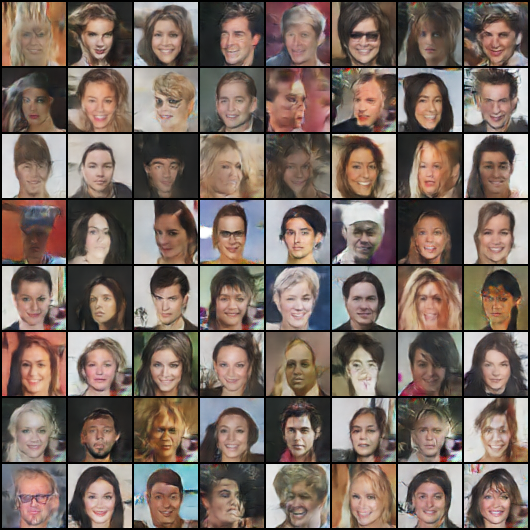

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


In [ ]:
jovian.log_metrics(loss_g = losses_g[-1], 
                   loss_d = losses_d[-1],
                   real_score = real_scores[-1],
                   fake_score = fake_scores[-1])

In [ ]:
torch.save(generator.state_dict(), 'G1.pth')
torch.save(discriminator.state_dict(), 'D1.pth')


In [ ]:
import cv2
import os 
vid_fname = 'gans_celebface_training1.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


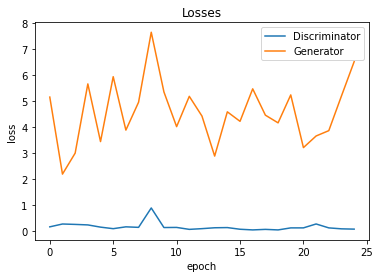

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses'); 

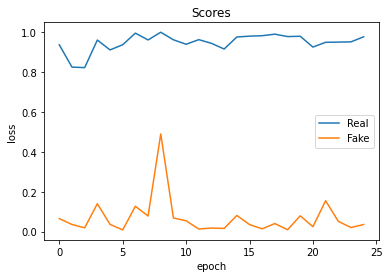

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Real', 'Fake'])
plt.title('Scores'); 

In [ ]:
import jovian
jovian.commit(project=project_name, outputs=['gans_celebface_training1.avi'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ai/swaingotnochill/gan-celeb-faces


'https://jovian.ai/swaingotnochill/gan-celeb-faces'